In [38]:
%load_ext autoreload
%autoreload 2
import os
import sys
import math
from util.add_timestep import gen_test, Scoring_2008
from util.tcn import TemporalConvNet
# from util.model_torch import Gating,Encoder,EncoderLayer,MultiHeadAttention

import torch.nn.functional as F 
from torch.nn.modules import MSELoss
import torch
from torch import nn
from torch import Tensor
from torch import optim
from torchsummary import summary
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

from data_provider.data_preprocess import scarle_rul

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn-whitegrid')#绘图的主题
plt.rcParams['font.sans-serif'] = 'Simsun'
plt.rcParams.update({'font.size': 12}) # 改变所有字体大小，改变其他性质类似

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


# 一.读取训练集

In [2]:
####制作表头
"""这个需要你自己再csv的数据中提前把与处理好的FFT或者2560维度的原始振动数据中手动添加UnitNumber和RUL"""
index_columns_names =  ["UnitNumber","RUL","ScaleRUL"]##RUL做完了后自己先进行归一化，这样更加方便训练预测


features_colums = ['s' + str(i) for i in range(1, 28)]###看你的数据维度，比如2560维度，那“67”就要改成2561
input_file_column_names = index_columns_names + features_colums

####归一的函数
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))
max_ab_scaler = MaxAbsScaler()

### 读取XJTU的前一步处理好的轴承数据

In [39]:
###这个是数据集的根目录，到时候你自己修改，我直接把
path_dir = "PHM2012/时域频域特征提取/退化比例0.5/"

bearing1_1 = pd.read_csv(path_dir+'bearing1_1.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) #'FFT_1_1_hor.csv'
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_1["ScaleRUL"]=scarle_rul(bearing1_1,0.8)
bearing1_1

,UnitNumber,RUL,ScaleRUL,s1,s2,s3,s4,s5,s6,s7,...,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27
0,1.0,1401.0,1.000000,2.010,2.010,-1.763,0.003465,3.773,0.450874,0.561746,...,39995.540337,2.179920e+08,8.145601,23.090346,8.833809,50.229382,0.439729,1.919761,3.699459,3.641912
1,1.0,1401.0,1.000000,1.725,1.915,-1.915,0.005609,3.640,0.428814,0.535112,...,38837.193146,2.352265e+08,10.826977,25.815448,6.919062,47.617447,0.438431,1.632413,3.288974,3.461249
2,1.0,1401.0,1.000000,1.776,1.901,-1.901,0.004196,3.677,0.421677,0.531158,...,39976.223057,2.502314e+08,9.167329,27.169644,8.005860,45.916113,0.523974,2.108270,3.539137,3.569674
3,1.0,1401.0,1.000000,1.878,1.910,-1.910,-0.001824,3.788,0.439284,0.554833,...,40153.888233,2.340395e+08,8.815508,27.234302,8.804939,45.555590,0.515523,1.864351,3.299086,3.910701
4,1.0,1401.0,1.000000,1.767,1.767,-1.660,-0.002582,3.427,0.453978,0.566652,...,40150.590976,2.279771e+08,8.674729,25.209834,8.312666,47.882627,0.456345,2.197434,3.010216,4.256149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,1.0,4.0,0.001784,44.295,48.148,-48.148,-0.090720,92.443,3.937015,6.707559,...,26013.249909,3.875871e+08,70.648200,18.837147,2.196808,3.319454,0.989150,1.843637,1.026172,1.139433
2799,1.0,3.0,0.001338,31.173,31.173,-30.664,-0.035204,61.837,3.109243,4.856943,...,32652.578727,6.140233e+08,60.370460,22.760345,2.950380,5.620680,1.458526,3.648069,1.821465,1.370075
2800,1.0,2.0,0.000892,30.043,38.767,-38.767,0.030579,68.810,3.430638,5.130328,...,30551.603895,5.376916e+08,61.528180,23.837142,1.901030,6.086002,1.255746,3.244670,1.178423,0.968807
2801,1.0,1.0,0.000446,39.994,43.604,-43.604,0.023402,83.598,3.703332,6.297325,...,26477.237984,4.128223e+08,70.052062,17.774716,2.077099,5.235475,1.105991,1.773737,1.087525,0.893395


In [42]:
bearing1_2 = pd.read_csv(path_dir+'bearing1_2.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_2["ScaleRUL"]=scarle_rul(bearing1_2,0.8)
bearing1_2

,UnitNumber,RUL,ScaleRUL,s1,s2,s3,s4,s5,s6,s7,...,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27
0,2.0,435.0,1.000000,1.767,2.330,-2.330,-0.000191,4.097,0.422611,0.538710,...,38226.610549,2.930217e+08,21.457463,14.605905,7.147902,47.784926,0.505992,1.083119,2.399434,5.015259
1,2.0,435.0,1.000000,1.982,1.982,-1.815,0.003091,3.797,0.402071,0.505577,...,39762.473013,2.578691e+08,16.223364,16.048350,7.739073,50.642687,0.579217,1.106490,2.627126,5.033694
2,2.0,435.0,1.000000,1.830,1.830,-1.768,-0.007988,3.598,0.429912,0.542441,...,39852.853144,2.778703e+08,15.833263,15.991180,6.339120,52.389740,0.876023,1.149548,1.986499,5.434629
3,2.0,435.0,1.000000,1.600,1.886,-1.886,0.022698,3.486,0.408112,0.515008,...,40143.509806,2.836462e+08,16.241892,15.824901,9.229126,49.016569,0.849462,1.129113,2.769658,4.939278
4,2.0,435.0,1.000000,1.536,1.705,-1.705,0.002741,3.241,0.386860,0.485601,...,40252.442806,3.219134e+08,19.991838,15.450292,8.355754,46.110873,1.032034,1.012417,2.931314,5.115479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,2.0,4.0,0.005747,8.986,10.342,-10.342,-0.000738,19.328,1.199922,1.639656,...,68200.236140,1.796529e+09,26.420318,13.835004,8.534816,17.076932,19.831940,5.900165,5.485619,2.915206
867,2.0,3.0,0.004310,8.064,8.697,-8.697,0.010361,16.761,1.209400,1.646489,...,69130.754294,1.848459e+09,25.520188,14.969696,6.835228,15.896822,19.662284,7.344420,6.394798,3.376563
868,2.0,2.0,0.002874,11.240,11.240,-10.822,0.005827,22.062,1.278976,1.781094,...,66337.032031,1.632533e+09,23.160306,14.849132,9.415155,19.491395,17.911921,5.362503,6.512973,3.296614
869,2.0,1.0,0.001437,17.649,17.649,-17.155,-0.012270,34.804,1.428479,2.135654,...,59052.321565,1.394821e+09,26.688911,19.882972,6.195990,21.210736,12.716332,4.644928,5.364339,3.295792


In [43]:
bearing1_3 = pd.read_csv(path_dir+'bearing1_3.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_3["ScaleRUL"]=scarle_rul(bearing1_3,0.8)
bearing1_3

bearing1_4 = pd.read_csv(path_dir+'bearing1_4.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_4["ScaleRUL"]=scarle_rul(bearing1_4,0.8)
bearing1_4

,UnitNumber,RUL,ScaleRUL,s1,s2,s3,s4,s5,s6,s7,...,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27
0,3.819592e-313,4.180332e-312,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.031906e-311,1.031317e-311,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
bearing1_4.shape

(1139, 1283)

In [44]:
bearing1_5 = pd.read_csv(path_dir+'bearing1_5.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_5["ScaleRUL"]=scarle_rul(bearing1_5,0.8)
bearing1_5
bearing1_6 = pd.read_csv(path_dir+'bearing1_6.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_6["ScaleRUL"]=scarle_rul(bearing1_6,0.8)
bearing1_6

,UnitNumber,RUL,ScaleRUL,s1,s2,s3,s4,s5,s6,s7,...,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27
0,6.0,1224.0,1.000000,2.624,2.624,-1.999,-0.066064,4.623,0.372450,0.477386,...,39583.144108,5.035049e+08,30.593722,20.846752,15.311968,20.345082,1.111622,1.153290,7.857780,2.779783
1,6.0,1224.0,1.000000,1.427,1.446,-1.446,0.012989,2.873,0.316230,0.400436,...,44266.769014,5.373893e+08,21.411347,20.300370,22.066216,20.293595,1.495950,1.319241,9.472566,3.640714
2,6.0,1224.0,1.000000,2.608,2.608,-2.430,0.014151,5.038,0.355654,0.465350,...,39917.967662,4.909379e+08,25.460515,31.843763,14.921645,15.616241,1.127800,0.976824,8.156980,1.896232
3,6.0,1224.0,1.000000,2.019,2.019,-1.677,0.005044,3.696,0.340157,0.431554,...,43573.047951,5.521789e+08,21.932055,23.632853,18.261040,19.359677,1.696497,1.356901,10.693880,3.067099
4,6.0,1224.0,1.000000,1.429,1.835,-1.835,-0.000507,3.264,0.331243,0.423018,...,41758.234827,5.172274e+08,26.544557,21.602525,16.582518,20.570778,1.410098,1.311925,8.912131,3.065467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,6.0,4.0,0.002043,9.150,9.473,-9.473,0.005998,18.623,0.874752,1.216225,...,64386.449508,1.697530e+09,27.763900,20.237603,6.801297,11.668512,15.510598,5.835135,8.037532,4.145423
2444,6.0,3.0,0.001532,8.220,8.220,-7.802,-0.003111,16.022,0.897295,1.243033,...,62274.454955,1.603639e+09,28.623061,21.015618,6.755117,12.324250,14.645034,4.428970,7.841094,4.366856
2445,6.0,2.0,0.001021,6.779,7.761,-7.761,-0.000201,14.540,0.877531,1.228672,...,63490.843592,1.689388e+09,29.280964,18.562298,5.848171,13.684200,15.462598,4.939537,8.076490,4.145743
2446,6.0,1.0,0.000511,8.926,8.926,-6.655,-0.016138,15.581,0.900197,1.253644,...,60756.807095,1.580188e+09,33.799376,14.591852,7.259640,14.777467,13.513875,4.862488,7.059393,4.135910


In [ ]:
for i in range(1,7):
    size=len

# 二.数据集制作

In [45]:
###要训练的轴承
train_df = pd.concat([bearing1_1,bearing1_2,bearing1_3], axis=0)
train_df

,UnitNumber,RUL,ScaleRUL,s1,s2,s3,s4,s5,s6,s7,...,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27
0,1.0,1401.0,1.000000,2.010,2.010,-1.763,0.003465,3.773,0.450874,0.561746,...,39995.540337,2.179920e+08,8.145601,23.090346,8.833809,50.229382,0.439729,1.919761,3.699459,3.641912
1,1.0,1401.0,1.000000,1.725,1.915,-1.915,0.005609,3.640,0.428814,0.535112,...,38837.193146,2.352265e+08,10.826977,25.815448,6.919062,47.617447,0.438431,1.632413,3.288974,3.461249
2,1.0,1401.0,1.000000,1.776,1.901,-1.901,0.004196,3.677,0.421677,0.531158,...,39976.223057,2.502314e+08,9.167329,27.169644,8.005860,45.916113,0.523974,2.108270,3.539137,3.569674
3,1.0,1401.0,1.000000,1.878,1.910,-1.910,-0.001824,3.788,0.439284,0.554833,...,40153.888233,2.340395e+08,8.815508,27.234302,8.804939,45.555590,0.515523,1.864351,3.299086,3.910701
4,1.0,1401.0,1.000000,1.767,1.767,-1.660,-0.002582,3.427,0.453978,0.566652,...,40150.590976,2.279771e+08,8.674729,25.209834,8.312666,47.882627,0.456345,2.197434,3.010216,4.256149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,3.0,4.0,0.002105,48.128,48.148,-48.148,-0.373158,96.276,7.652456,10.025694,...,55897.897559,1.618069e+09,47.281263,16.221526,2.711496,8.940680,12.243512,6.092636,1.818272,4.690615
2371,3.0,3.0,0.001579,48.128,48.148,-48.148,-1.559198,96.276,7.430990,9.953157,...,56866.099873,1.704606e+09,46.522144,15.433219,3.552388,7.246882,8.934587,10.872123,2.115769,5.322888
2372,3.0,2.0,0.001053,48.128,48.148,-48.148,0.602805,96.276,7.833442,10.339682,...,47254.359930,1.268774e+09,53.307104,19.098965,2.622412,6.269279,6.290899,5.117103,2.341886,4.952353
2373,3.0,1.0,0.000526,37.144,39.336,-39.336,0.093508,76.480,7.281911,9.499991,...,34690.214117,7.119836e+08,61.368248,21.005992,2.049573,6.779524,2.594586,3.311504,1.156026,1.734546


In [46]:
###要测试的轴承
test_df = pd.concat([bearing1_5], axis=0)
test_df
test2_df=pd.concat([bearing1_6], axis=0)

In [47]:
###时间步
sequence_length = 64
mask_value = 0
feats =features_colums
# feats = ['s' + str(i) for i in range(1, 67)]##需要的特征数据维度，可以自己选择

In [48]:
### 数据集归一化
"""先使用fit_transform,后使用transform"""

train_df[feats] = max_ab_scaler.fit_transform(train_df[feats])
test_df[feats] = max_ab_scaler.transform(test_df[feats])
test2_df[feats]=max_ab_scaler.transform(test2_df[feats])

In [49]:
train_df

,UnitNumber,RUL,ScaleRUL,s1,s2,s3,s4,s5,s6,s7,...,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27
0,1.0,1401.0,1.000000,0.041764,0.041746,-0.036616,0.002222,0.039189,0.057558,0.054329,...,0.401907,0.085495,0.089835,0.563964,0.390861,0.954405,0.007756,0.096908,0.194021,0.284852
1,1.0,1401.0,1.000000,0.035842,0.039773,-0.039773,0.003597,0.037808,0.054741,0.051753,...,0.390267,0.092254,0.119407,0.630522,0.306141,0.904776,0.007733,0.082403,0.172493,0.270721
2,1.0,1401.0,1.000000,0.036902,0.039482,-0.039482,0.002691,0.038192,0.053830,0.051371,...,0.401712,0.098139,0.101104,0.663598,0.354228,0.872449,0.009242,0.106424,0.185613,0.279202
3,1.0,1401.0,1.000000,0.039021,0.039669,-0.039669,-0.001170,0.039345,0.056078,0.053661,...,0.403498,0.091789,0.097224,0.665177,0.389584,0.865599,0.009093,0.094111,0.173024,0.305875
4,1.0,1401.0,1.000000,0.036715,0.036699,-0.034477,-0.001656,0.035596,0.057954,0.054804,...,0.403465,0.089411,0.095671,0.615731,0.367803,0.909815,0.008049,0.110924,0.157874,0.332894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,3.0,4.0,0.002105,1.000000,1.000000,-1.000000,-0.239327,1.000000,0.976896,0.969633,...,0.561706,0.634596,0.521450,0.396198,0.119973,0.169881,0.215956,0.307551,0.095361,0.366876
2371,3.0,3.0,0.001579,1.000000,1.000000,-1.000000,-1.000000,1.000000,0.948624,0.962617,...,0.571435,0.668535,0.513078,0.376945,0.157179,0.137698,0.157592,0.548815,0.110963,0.416329
2372,3.0,2.0,0.001053,1.000000,1.000000,-1.000000,0.386612,1.000000,1.000000,1.000000,...,0.474849,0.497605,0.587908,0.466478,0.116031,0.119122,0.110961,0.258307,0.122822,0.387348
2373,3.0,1.0,0.000526,0.771775,0.816981,-0.816981,0.059972,0.794383,0.929593,0.918789,...,0.348594,0.279235,0.676811,0.513055,0.090686,0.128817,0.045764,0.167162,0.060629,0.135667


### 训练集数据制作

In [50]:
#生成带时间步的三维数据
x_train=np.concatenate(list(list(gen_test(train_df[train_df['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in train_df['UnitNumber'].unique()))
print(x_train.shape)

(6049, 64, 27)


In [51]:
#t获取训练集RUL标签
y_train = train_df.ScaleRUL.values###这里的RUL是列名，如果不是这样命名要修改
y_train.shape


(6049,)

### 验证集数据制作

In [52]:
#生成带时间步的三维数据
x_test=np.concatenate(list(list(gen_test(test_df[test_df['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in test_df['UnitNumber'].unique()))
print(x_test.shape)

(2463, 64, 27)


In [53]:
#t获取训练集RUL标签
y_test = test_df.ScaleRUL.values
y_test.shape


(2463,)

### 测试集制作

In [54]:
x_test2=np.concatenate(list(list(gen_test(test2_df[test2_df['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in test2_df['UnitNumber'].unique()))
print(x_test2.shape)
y_test2 = test2_df.ScaleRUL.values
y_test2.shape


(2448, 64, 27)


(2448,)

In [55]:
y_test

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.01522843e-03, 5.07614213e-04, 0.00000000e+00])

### Torch中的数据形式转换

In [56]:
##需要验证集，请自己从x_train中随机划分0.1-0.3的样本作为验证集
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
#x_vaild
#y_vaild
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

#测试集
x_test2=torch.Tensor(x_test2)
y_test2=torch.Tensor(y_test2)

In [57]:
print("训练集的特征形状, x_train ：", x_train.shape)
print("训练集的标签形状, y_train ：", y_train.shape)
print("验证集的特征形状, x_val ：", x_test.shape)
print("验证集的标签形状, y_val ：", y_test.shape)
print("测试集的特征形状，x_test：", x_test2.shape)
print("测试集的标签形状，y_test：", y_test2.shape)

训练集的特征形状, x_train ： torch.Size([6049, 64, 27])
训练集的标签形状, y_train ： torch.Size([6049])
验证集的特征形状, x_val ： torch.Size([2463, 64, 27])
验证集的标签形状, y_val ： torch.Size([2463])
测试集的特征形状，x_test： torch.Size([2448, 64, 27])
测试集的标签形状，y_test： torch.Size([2448])


In [58]:
"""批大小提前在数据划分中自己定好，这是Torch中比较特殊的"""
batch_size = 128

data_train_loader  = DataLoader(TensorDataset(x_train,y_train),shuffle=False,
                               batch_size=batch_size,num_workers=0)
data_test_loader = DataLoader(TensorDataset(x_test,y_test),shuffle=False,
                             batch_size=batch_size,num_workers=0)
data_test2_loader=DataLoader(TensorDataset(x_test2,y_test2),shuffle=False,
                           batch_size=batch_size,num_workers=0)

## 评估函数的定义

In [59]:
"""在model(test)之前，需要加上model.eval()，否则的话，有输入数据，即使不训练，它也会改变权值。
    这是model中含有BN层和Dropout所带来的的性质。
    eval()时，框架会自动把BN和Dropout固定住，不会取平均，而是用训练好的值，
    不然的话，一旦test的batch_size过小，很容易就会被BN层导致生成图片颜色失真极大！！！！！！
    在做one classification的时候，训练集和测试集的样本分布是不一样的，尤其需要注意这一点。
"""
##output.detach().cpu().numpy())#能缩短计算时间
def Epoch_evaluate(net,loader):
    net.eval()
    min_val_loss = 0.0
    val_rmse=0.0
    val_score=0.0
    i = 0
    preds = []
    true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
#             data = data.view(-1, input_channels, seq_length)#permute(0,2,1)#
            #上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码
            
            output = net(data)
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            
            min_val_loss +=Losses(output, target).item()
            i +=1
        min_val_loss = min_val_loss/i
        val_rmse = np.sqrt(min_val_loss)
        preds = np.concatenate(preds)
        true = np.concatenate(true)
#         val_score =np.float(Scoring_2008(true,preds))
        return round(min_val_loss,5),np.round(val_rmse,5)
    
#现在都是对的了
def Last_evaluate2(net,loader):
    net.eval()
    min_val_loss = 0.0
    np_mse=0.0
    preds = []
    true = []
    i=0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
#             data = data.view(-1, input_channels, seq_length)#permute(0,2,1)
               #上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码           
            output = net(data)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            min_val_loss +=Losses(output, target).item()
            i+=1
        min_val_loss=min_val_loss/i
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        return np.round(preds,4),np.round(true,5)

# 三.构建LSTM和BilSTM模型

In [23]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BiLSTM, self).__init__()
        # 输入数据的特征维数
        self.input_size = input_size
        # 隐藏层的大小
        self.hidden_size = hidden_size
        # BiLSTM层数
        self.num_layers = num_layers
        # 输出数据的维数（一维时间序列）
        self.output_size = output_size

        # 定义BiLSTM层，输入形状为（batch_size, seq_len, input_size）
        # bidirectional参数设为True表示双向LSTM，输出的隐藏状态会拼接正向和反向的结果
        self.bilstm = nn.LSTM(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              batch_first=True,
                              bidirectional=True)
        #Dropout层
        self.dropout=nn.Dropout(dropout)
        
        # 定义全连接层，将最后一个时间步的隐藏状态映射到输出维度
        # 因为是双向LSTM，所以全连接层的输入维度要乘以2
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        # 初始化隐藏状态和单元状态，形状为（num_layers*2, batch_size, hidden_size）
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)

        # 通过BiLSTM层，得到输出和最后一个时间步的隐藏状态和单元状态
        out,(hn,cn) = self.bilstm(x,(h0,c0))

        # 只取最后一个时间步的输出，形状为（batch_szie,hiddden_szie*2）
        out=out[:,-1,:]
        
        out=self.dropout(out)

        # 通过全连接层，得到最终输出，形状为（batch_szie,output_szie）
        out=self.fc(out)

        return out


In [24]:
x_train.shape[2]

27

## LSTM()模型的训练参数设置

In [60]:

#自己修改，假设输入数据的特征维数为input_channels，隐藏层大小为20，LSTM层数为4，输出维度为1
## 序列参数
seq_length = sequence_length
dropout=0.1
# 输入数据的特征维数
input_channels=x_train.shape[2]

###自己改成
model = BiLSTM(input_size=input_channels,
             hidden_size=32,
             num_layers=4,
             output_size=1,dropout=dropout).to(device)
optimizer = torch.optim.RMSprop(model.parameters())
"""
学习率衰减技术2：连续多少次无提升则衰减到原来的0.1倍
"""
#根据每个epoch验证集指标自适应调整学习率，学习率为原来的0.1倍，mode判断指标改善方向，min代表越小越好，
#如果指标在patience个训练周期内没有改善，调度器将学习率按照设定factor进行缩小
epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=50,
                                                             min_lr=0.0001)
Losses = nn.MSELoss()

#这个summary是torchsummary的打印参数，对LSTM网络无效，会报错
# summary(model,(36, 10))
###因此需要替换成这个
from torchinfo import summary

summary(model, input_size=(batch_size,seq_length, input_channels))
# summary(model, input_size=(128,36, 10))
###这里是有四层SLTM在一起，神经元数目相同，打印显示只有一层而已
###如果你需要LSTM每一层的神经元不同，修改 nn.BiLSTM(input_size=input_size,
#                             hidden_size=hidden_size,
#                             num_layers=1,
#                             batch_first=True,
#                             bidirectional=True)
# 然后自己添加就好

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [128, 1]                  --
├─LSTM: 1-1                              [128, 64, 64]             90,880
├─Dropout: 1-2                           [128, 64]                 --
├─Linear: 1-3                            [128, 1]                  65
Total params: 90,945
Trainable params: 90,945
Non-trainable params: 0
Total mult-adds (M): 744.50
Input size (MB): 0.88
Forward/backward pass size (MB): 4.20
Params size (MB): 0.36
Estimated Total Size (MB): 5.44

## 模型训练主程序

In [61]:
%%time
###这个patience是连续150次，loss还是没有下降就停止运行
patience = 100
###这个是用于更新初始的val_loss的阈值
T_val_loss = 9999
epochs=200
counter = 0
train_loss= []
train_flood = []
val_loss = []
all_epochs = []
lr_step = []
###这个是模型权重的保存
save_dir="TorchModel_BiLSTM/"
if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        
for epoch in range(1, epochs+1):
    epoch_loss = 0
    flood_loss = 0
    model.train()
    for batch_idx,(data, target) in enumerate(data_train_loader):
        total = 0
        data, target = data.to(device), target.to(device)
#         data = data.view(-1, input_channels, seq_length)#permute(0,2,1)
        #上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码
    
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze(1)
        loss = Losses(output, target)
        loss.backward()
#         #这里添加梯度回退技巧，有一篇论文用到，你们可以试试
#         b = torch.Tensor([145]).to(device)
#         flood = (loss-b).abs()+b
#         flood.backward()
        optimizer.step()

        epoch_loss += loss.item()
#         flood_loss +=loss.item()
        total=batch_idx+1
    epoch_loss = epoch_loss/total
#     flood_loss = flood_loss/total
    ##############################还是要注意，不能把你要测试的数据放在这里进行验证####################################
    """不能使用是data_test_loader的数据作为  验证集，否则是算作弊
         需要做的办法：从训练集中随机，打乱抽取0.1-0.3的样本作为验证集 data_val_loader
         这个在TensorFlow中始很容易实现，但是Torch中我这一块没有研究，我自己代码是以TF2.X框架为主
         这个你们需要自己去查查，怎么制作新的validdata
    """
    min_val_loss ,val_rmse = Epoch_evaluate(model,data_test_loader) ###

    #学习率衰减策略 
    epoch_scheduler.step(min_val_loss)
    lr_current = optimizer.param_groups[0]['lr']
    lr_step.append(lr_current)
    
    print('epoch [{}/{}], loss:{:.5f}, val_loss:{}, val_RMSE:{}, lr:{}'.format(epoch,epochs,
                                                                        epoch_loss,min_val_loss,val_rmse,lr_current))#{:.4f}  
    ##这里是保存最后一个epoch的权重
    torch.save(model.state_dict(),os.path.join(save_dir, "model_on_last_epoch.pth"))
        
    if epoch % 1 == 0:
        train_loss.append(epoch_loss)
        val_loss.append(min_val_loss)
        all_epochs.append(epoch)
    """这里是设置训练的early stop patience """ 
    #对测试集上的test_loss进行监视，并设置patience，保存在测试集上表现最好的model
    if T_val_loss >=min_val_loss:
        T_val_loss = min_val_loss
        #print("Saving...")
        best_epoch = epoch#找到最佳的epoch编号
        torch.save(model.state_dict(),os.path.join(save_dir, "model_onTestBest.pth"))
        counter = 0
    else: 
        counter += 1
    if counter == patience:
        break
        
    
    

epoch [1/200], loss:0.47853, val_loss:0.35618, val_RMSE:0.5968, lr:0.01
epoch [2/200], loss:0.08904, val_loss:0.25182, val_RMSE:0.50182, lr:0.01
epoch [3/200], loss:0.09305, val_loss:0.23492, val_RMSE:0.48469, lr:0.01
epoch [4/200], loss:0.09542, val_loss:0.2295, val_RMSE:0.47907, lr:0.01
epoch [5/200], loss:0.09718, val_loss:0.22628, val_RMSE:0.47569, lr:0.01
epoch [6/200], loss:0.09739, val_loss:0.22698, val_RMSE:0.47642, lr:0.01
epoch [7/200], loss:0.09690, val_loss:0.22505, val_RMSE:0.47439, lr:0.01
epoch [8/200], loss:0.09702, val_loss:0.2667, val_RMSE:0.51643, lr:0.01
epoch [9/200], loss:0.08760, val_loss:0.19214, val_RMSE:0.43833, lr:0.01
epoch [10/200], loss:0.11701, val_loss:0.28649, val_RMSE:0.53524, lr:0.01
epoch [11/200], loss:0.07228, val_loss:0.12424, val_RMSE:0.35247, lr:0.01
epoch [12/200], loss:0.04102, val_loss:0.11701, val_RMSE:0.34207, lr:0.01
epoch [13/200], loss:0.04524, val_loss:0.10814, val_RMSE:0.32884, lr:0.01
epoch [14/200], loss:0.03540, val_loss:0.11358, va

epoch [112/200], loss:0.00407, val_loss:0.12828, val_RMSE:0.35817, lr:0.001
epoch [113/200], loss:0.00398, val_loss:0.12726, val_RMSE:0.35674, lr:0.001
epoch [114/200], loss:0.00391, val_loss:0.12726, val_RMSE:0.35674, lr:0.001
epoch [115/200], loss:0.00393, val_loss:0.12758, val_RMSE:0.35719, lr:0.001
epoch [116/200], loss:0.00386, val_loss:0.12751, val_RMSE:0.35708, lr:0.001
epoch [117/200], loss:0.00378, val_loss:0.1289, val_RMSE:0.35902, lr:0.001
epoch [118/200], loss:0.00369, val_loss:0.12733, val_RMSE:0.35683, lr:0.001
epoch [119/200], loss:0.00358, val_loss:0.12675, val_RMSE:0.35601, lr:0.001
epoch [120/200], loss:0.00354, val_loss:0.12758, val_RMSE:0.35719, lr:0.001
epoch [121/200], loss:0.00362, val_loss:0.12716, val_RMSE:0.3566, lr:0.001
epoch [122/200], loss:0.00338, val_loss:0.12811, val_RMSE:0.35792, lr:0.001
epoch [123/200], loss:0.00340, val_loss:0.12672, val_RMSE:0.35598, lr:0.001
epoch [124/200], loss:0.00337, val_loss:0.12847, val_RMSE:0.35843, lr:0.001
epoch [125/200

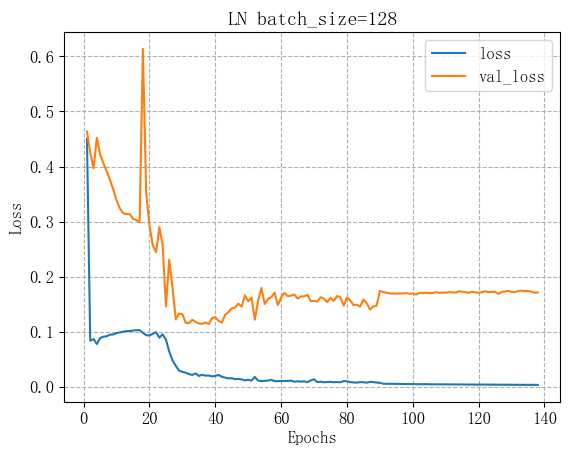

In [28]:
"""训练loss查看"""
plt.grid(linestyle="--")
plt.plot(all_epochs,train_loss)
plt.plot(all_epochs,val_loss)
plt.title('LN batch_size=128')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig('TorchModel/loss.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()

In [29]:
"""评估"""
model.load_state_dict(torch.load(os.path.join(save_dir, "model_onTestBest.pth")))
train_metrics=[]
test_metrics =[]
train_metrics = Epoch_evaluate(model,data_train_loader)
test_metrics = Epoch_evaluate(model,data_test2_loader) 
print('epoch [{}/{}], loss:{:.4f},     RMSE:{},'.format(best_epoch,epochs,train_metrics[0],train_metrics[1]))
print('epoch [{}/{}], test_loss:{:.4f}, test_RMSE:{}'.format(best_epoch,epochs,test_metrics[0],test_metrics[1]))

epoch [38/200], loss:0.0575,     RMSE:0.23979,
epoch [38/200], test_loss:0.1124, test_RMSE:0.33531


In [62]:
##保存评价指标：对于轴承
df = pd.DataFrame({'MSE':[train_metrics[0]] ,
                   'RMSE': [train_metrics[1]],})

df.transpose().to_csv("TorchModel/评估得分.txt",
                      mode='w',header=['train'],sep=' ',index=["MSE","RMSE"])
df = pd.DataFrame({'MSE':[test_metrics[0]] ,
                   'RMSE': [test_metrics[1]],})

df.transpose().to_csv("TorchModel/评估得分.txt",
                      mode='a',header=['test'],sep=' ',index=["MSE","RMSE"])

# 四.轴承RUL预测与可视化

## 训练集的预测

In [63]:
##训练集的预测
y_train_preds,y_train_true = Last_evaluate2(model,data_train_loader)

In [64]:
"""保存预测的RUL值与实际的RUL值"""

y_train_All=pd.DataFrame({'Pre':y_train_preds,
                   'Actual':y_train_true})
y_train_All.to_csv("TorchModel/y_train_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

## 测试集的预测

In [65]:
##测试集的预测
y_test_preds,y_test_true = Last_evaluate2(model,data_test2_loader)

In [66]:
"""保存预测的RUL值与实际的RUL值"""

y_All=pd.DataFrame({'Pre':y_test_preds,
                   'Actual':y_test_true})
y_All.to_csv("TorchModel/y_test2_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

## 轴承的可视化以及RUL预测数据的保存

In [67]:
# 可视化
"""这里轴承的可视化，不包括ma、eam、SG滤波三种平滑方法，有兴趣自己添加或者再找我"""
"""这里以XJTU-SY_Bearing_Datasets\37.5Hz11kN的数据集为例
训练集:   Bearing2-1：长度491
              Bearing2-2：长度161
              Bearing2-3：长度533
测试集:   Bearing2-4：长度42
              Bearing2-5：长度339
"""
from sklearn.metrics import mean_squared_error

def calculateScore(y_pred, y_test):
    y_pred = list(map(lambda x: x[0], y_pred))
    return mean_squared_error(y_pred, y_test)

def plotUnitLines_y_test(y_test, y_pred, unit, Bpath='', figsize=[8, 6], plotname='', dirs=None):

    mse = mean_squared_error(y_test, y_pred)

    x = range(len(y_pred))

    data_list = []
   

    fig = plt.figure(figsize=figsize)
   
    plt.plot(x, y_pred, color="red", label='原始预测', linewidth=1)
    plt.plot(x, y_test, color='blue', label='实际值', linewidth=1)
    plt.xlim(0, max(x))
    plt.ylim(0, )
    plt.grid(linestyle="--")
    plt.title('Bearing1_' + str(unit) + ', RMSE: ' + str('%.5f'% pow(mse,0.5)) ,
              fontsize=12)
    plt.ylabel('RUL(%)', fontsize=12)
    plt.xlabel('Running Time (*10s)', fontsize=12)
    plt.legend(fontsize=12)
    fig.tight_layout()

    if len(plotname) > 0:
        save_dir = dirs + Bpath
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_dir + plotname + ".png", bbox_inches='tight', dpi=300, format='png')  # 600
        np.savetxt(save_dir + plotname + "RULPre.csv", y_pred)
        np.savetxt(save_dir + plotname + "Act_RUL.csv", y_test)
        np.savetxt(save_dir + plotname + "x_axis.csv", x)
    plt.show()

## 注意用y_test_true和y_train_true绘图会出现锯齿

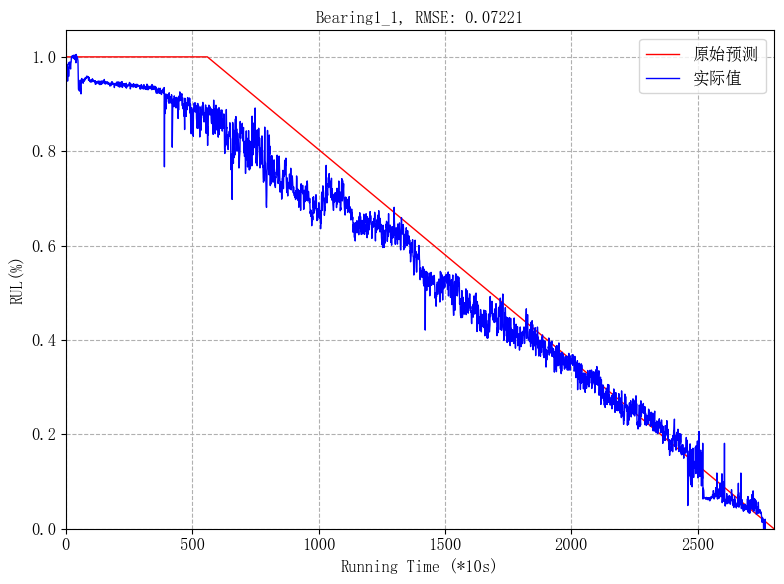

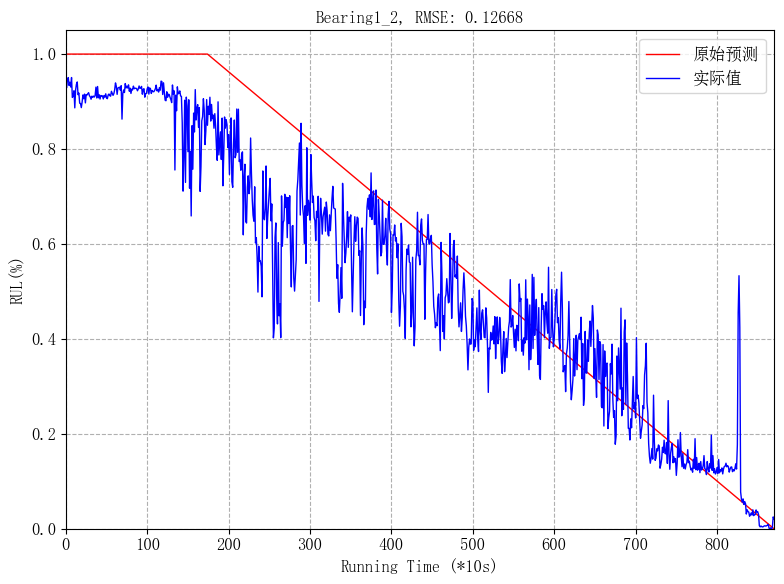

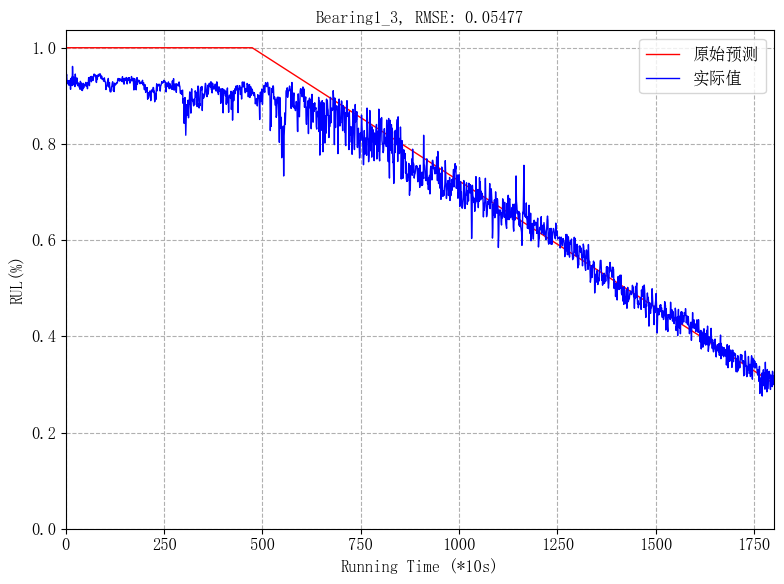

In [68]:
###训练集可视化
plotUnitLines_y_test(y_train_preds[:2803], y_train[:2803], unit=1, 
                     Bpath="best_epoch_result/B1_1/", figsize=[8, 6], plotname='B1_1_', dirs=save_dir)
plotUnitLines_y_test(y_train_preds[2803:2803+871], y_train[2803:2803+871], unit=2,
                     Bpath="best_epoch_result/B1_2/", figsize=[8, 6], plotname='B1_2_', dirs=save_dir)
plotUnitLines_y_test(y_train_preds[2803+871:2803+871+1802 ], y_train[2803+871: 2803+871+1802 ], unit=3,
                     Bpath="best_epoch_result/B1_3/", figsize=[8, 6], plotname='B1_3_', dirs=save_dir)

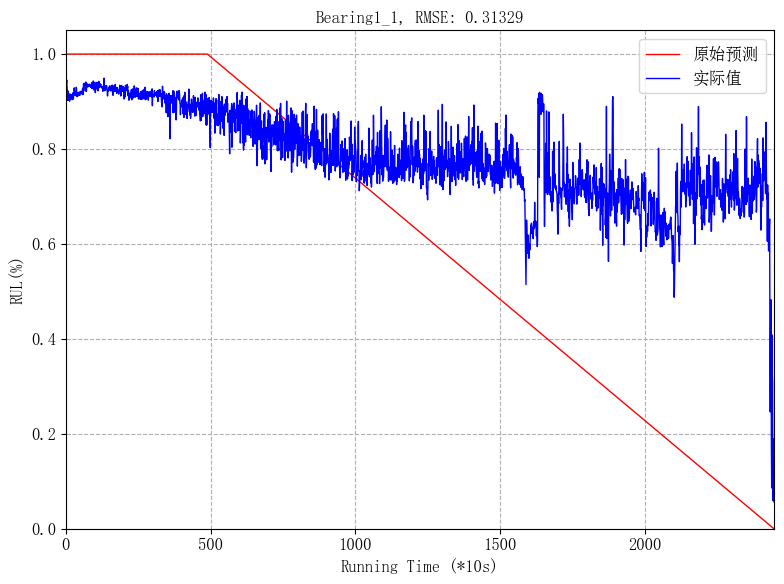

In [69]:
###测试集可视化
plotUnitLines_y_test(y_test_preds, y_test_true, unit=1, 
                     Bpath="best_epoch_result/B1_6/", figsize=[8, 6], plotname='B1_6_', dirs=save_dir)
# plotUnitLines_y_test(y_test_preds[:2302], y_test_true[:2302], unit=1, 
#                      Bpath="best_epoch_result/B1_5/", figsize=[8, 6], plotname='B1_5_', dirs=save_dir)
# plotUnitLines_y_test(y_test_preds[2302:], y_test_true[2302:], unit=2,
#                      Bpath="best_epoch_result/B1_6/", figsize=[8, 6], plotname='B1_6_', dirs=save_dir)

### 上述图不是FFT和原始信号特征，效果果然不好，，，还是要在特征层面下足功夫

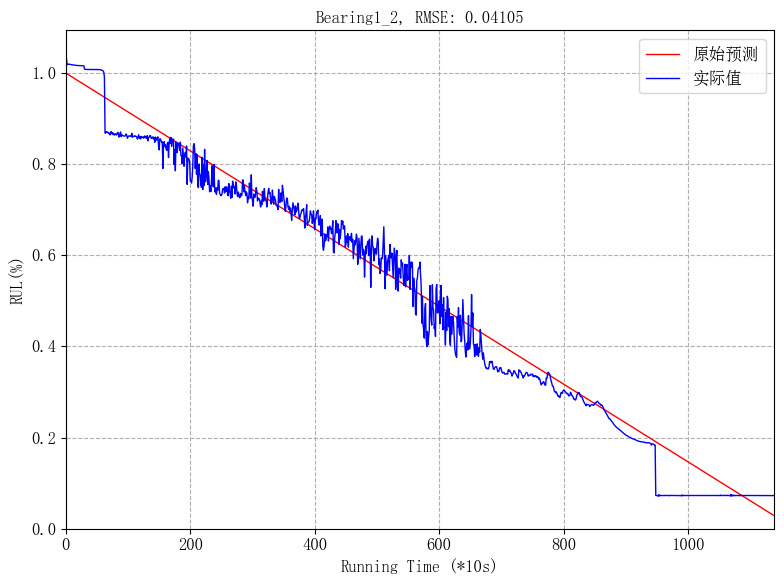

In [212]:
plotUnitLines_y_test(y_test_preds, y_test_true, unit=2,
                     Bpath="best_epoch_result/B1_4/", figsize=[8, 6], plotname='B1_4_', dirs=save_dir)

In [207]:
y_test_preds[2302:]

array([], dtype=float32)